In [1]:
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile
import sqlite3
import os

# Function to download Excel file from a ZIP archive and convert it to a DataFrame
def download_and_convert_to_csv(url):
    """Download Excel file from a ZIP archive and convert it to a DataFrame."""
    print(f"Downloading data from {url}...")
    response = requests.get(url)
    with ZipFile(BytesIO(response.content)) as myzip:
        with myzip.open(myzip.namelist()[0]) as myfile:
            df = pd.read_excel(myfile, engine='openpyxl')
            print(f"Columns in the {url.split('/')[-1]} dataset:", df.columns.tolist())  # Show actual columns
    return df

# Function to preprocess data (select relevant columns, rename, and clean)
def preprocess_data(job_df, food_df):
    """Preprocess data by selecting relevant columns, renaming them, and cleaning data."""

    # Select and rename columns in the job dataset
    job_df = job_df[['DUID', 'JOBTYPE', 'HRSPRWK', 'GROSSPAY', 'DAYWAGE', 'OFFTAKEI']].rename(columns={
        'DUID': 'dwelling_unit_id',
        'JOBTYPE': 'job_type',
        'HRSPRWK': 'hours_per_week',
        'GROSSPAY': 'gross_pay',
        'DAYWAGE': 'daily_wage',
        'OFFTAKEI': 'offered_insurance_accepted'
    })

    # Select and rename columns in the food dataset
    food_df = food_df[['DUID', 'FSOUT42', 'FSLAST42', 'FSAFRD42', 'FSSKIP42', 'FSWT42']].rename(columns={
        'DUID': 'dwelling_unit_id',
        'FSOUT42': 'food_out_worry',
        'FSLAST42': 'food_not_last',
        'FSAFRD42': 'could_not_afford_meal',
        'FSSKIP42': 'meal_skip',
        'FSWT42': 'food_weight'
    })

    # Convert relevant columns to numeric and remove invalid (non-numeric) values
    numeric_columns_job = ['hours_per_week', 'gross_pay', 'daily_wage', 'offered_insurance_accepted']
    numeric_columns_food = ['food_out_worry', 'food_not_last', 'could_not_afford_meal', 'meal_skip', 'food_weight']

    for column in numeric_columns_job:
        job_df[column] = pd.to_numeric(job_df[column], errors='coerce')

    for column in numeric_columns_food:
        food_df[column] = pd.to_numeric(food_df[column], errors='coerce')

    # Drop rows with any remaining NaN values
    job_df = job_df.dropna()
    food_df = food_df.dropna()

    # Merge datasets on 'dwelling_unit_id' (Dwelling Unit ID)
    merged_df = job_df.merge(food_df, on='dwelling_unit_id', how='inner')

    return merged_df

# Main execution function
def main():
    # URLs to the ZIP files containing the data
    job_url = 'https://meps.ahrq.gov/mepsweb/data_files/pufs/h237/h237xlsx.zip'
    food_security_url = 'https://meps.ahrq.gov/mepsweb/data_files/pufs/h240/h240xlsx.zip'

    # Download and process the datasets
    job_df = download_and_convert_to_csv(job_url)
    food_df = download_and_convert_to_csv(food_security_url)

    # Preprocess and merge data
    merged_df = preprocess_data(job_df, food_df)

    # Display the merged DataFrame head and the first 15 rows
    print("Head of the merged DataFrame:")
    print(merged_df.head())

    # Ensure the working directory exists
    data_directory = './working'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save the merged DataFrame to a CSV file in the working directory
    output_csv = os.path.join(data_directory, 'merged_dataset.csv')
    merged_df.to_csv(output_csv, index=False, encoding='utf-8-sig')
    print(f"\nMerged dataset saved as {output_csv}")

    # Create an SQLite database connection and save the table
    db_path = os.path.join(data_directory, 'merged_dataset.db')
    conn = sqlite3.connect(db_path)
    merged_df.to_sql('merged_data', conn, if_exists='replace', index=False)
    print(f"Database saved as {db_path}")
    conn.close()

    # Display confirmation message
    print("Data pipeline completed successfully!")

# Execute the script
if __name__ == '__main__':
    main()


Columns in the h237xlsx.zip dataset: ['JOBSIDX', 'JOBIDX', 'JOBNUM', 'ESTBIDX', 'DUPERSID', 'DUID', 'PID', 'RN', 'OrigRnd', 'PANEL', 'JSTRTM', 'JSTRTY', 'JSTOPM', 'JSTOPY', 'RETIRJOB', 'SUBTYPE', 'STILLAT', 'TYPECHGD', 'MAIN_JOB', 'DIFFWAGE', 'StillWorkFTPT', 'WhyChngPTToFT', 'WhyChngFTToPT', 'STILLWRK', 'OFFTAKEI', 'NOWTAKEI_M22', 'ESTBTHRU', 'INSESTB', 'HIDISAVW', 'RvwTotNumEmp', 'WHY_LEFT_M18', 'JOBTYPE', 'NUMEMPS', 'ESTMATE1_M19', 'MORELOC', 'BUSINC', 'PROPRIET', 'TYPEEMPL', 'YLEFT_M18', 'YNOBUSN_M18', 'HRSPRWK', 'HRS35WK', 'TEMPJOB', 'SESNLJOB', 'SICKPAY', 'PAYDRVST', 'PAYVACTN', 'RETIRPLN', 'WKLYAMT', 'EMPLINS', 'JOBHASHI', 'OFFRDINS', 'DIFFPLNS', 'ANYINS', 'INUNION', 'PROVDINS', 'EmplUnionProv', 'HHMEMBER_M18', 'TOTLEMP_M18', 'TotNumEmp', 'SALARIED', 'HOWPAID', 'DAYWAGE', 'HRSPRDY', 'MAKEAMT', 'PERUNIT_M18', 'HRLYWAGE', 'MORE10', 'MORE15', 'MOREMINM', 'GROSSPAY', 'GROSSPER', 'SALRYWKS', 'HRSALBAS', 'EARNTIPS', 'EARNBONS', 'EARNCOMM', 'TIPSAMT', 'TIPSUNIT_M18', 'BONSAMT', 'BONSUN

Loading CSV file...

First 5 rows of the dataset:
   dwelling_unit_id  job_type  hours_per_week  gross_pay  daily_wage  \
0           2460006         2              43       -1.0          -1   
1           2460006         2              43       -1.0          -1   
2           2460006         2              43       -1.0          -1   
3           2460010         2              40       -1.0          -1   
4           2460010         2              40   110000.0          -1   

   offered_insurance_accepted  food_out_worry  food_not_last  \
0                          -1               3              3   
1                          -1               3              3   
2                          -1               3              3   
3                          -1               3              3   
4                          -1               3              3   

   could_not_afford_meal  meal_skip   food_weight  
0                      3         -1  16027.953624  
1                      3    

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


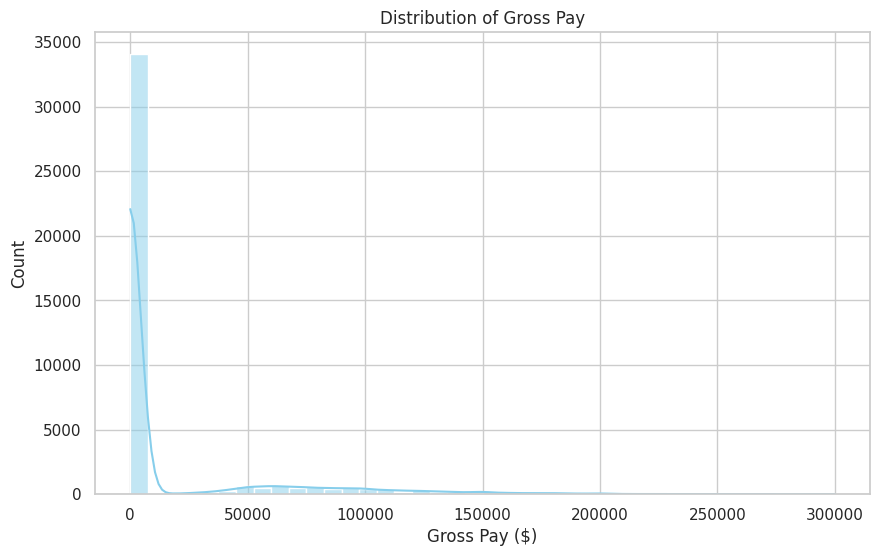

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


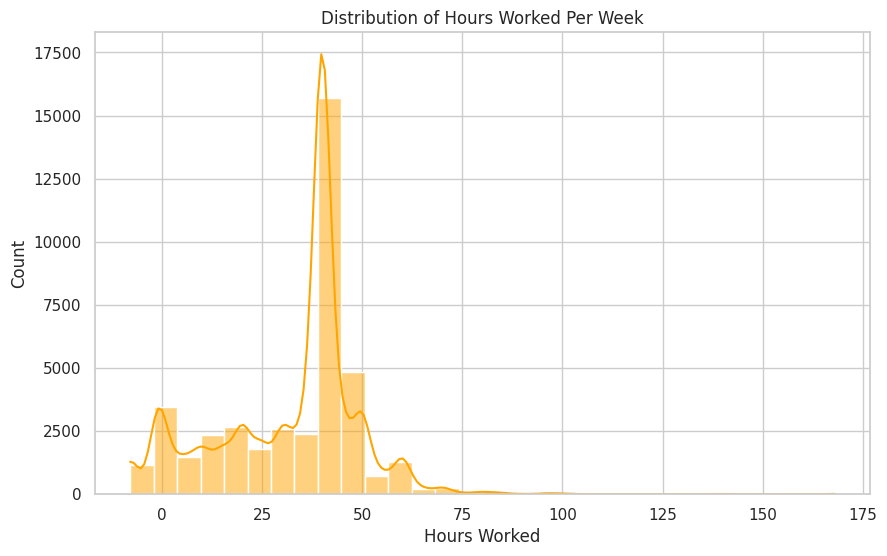

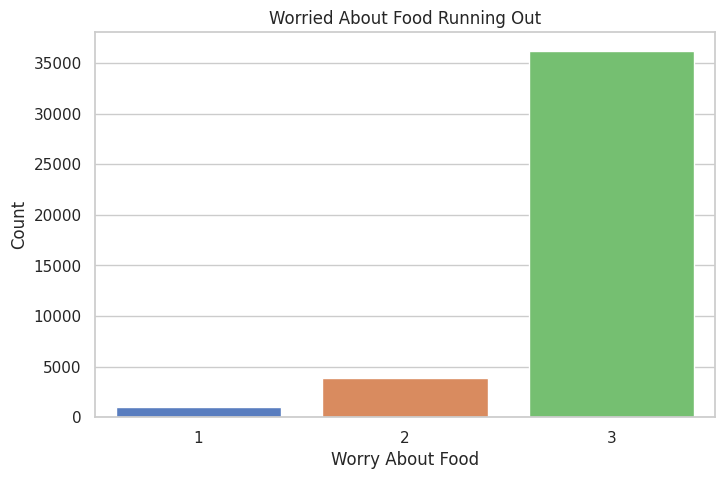

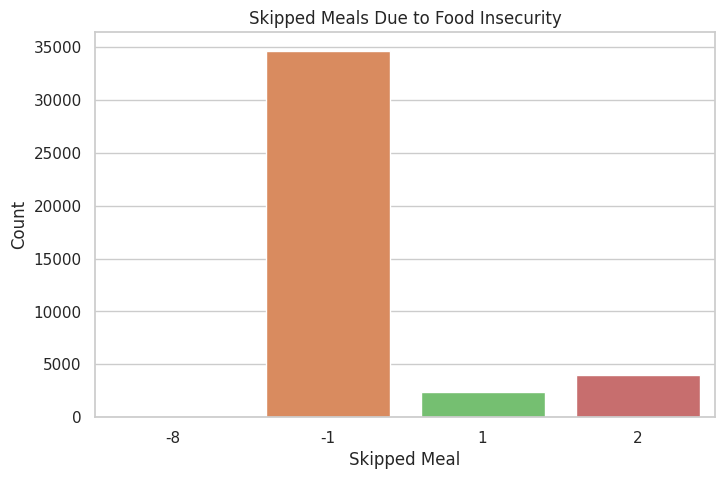

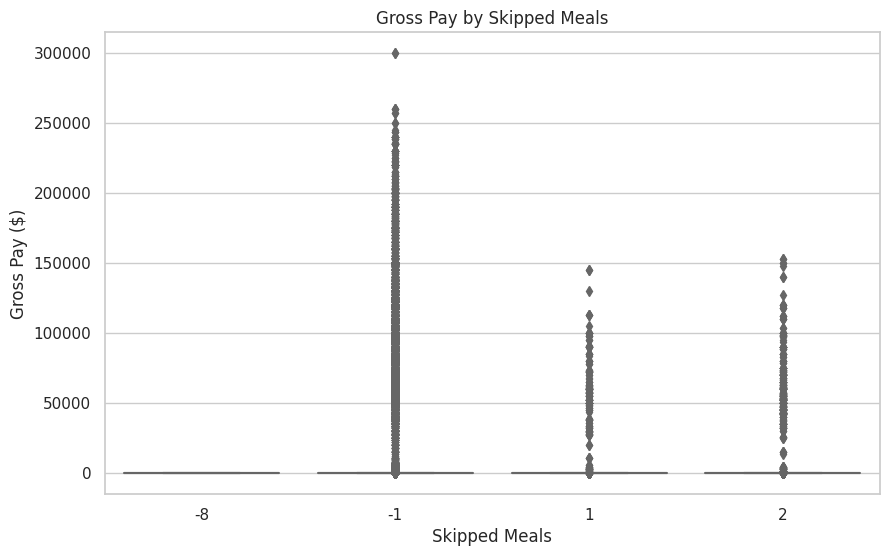

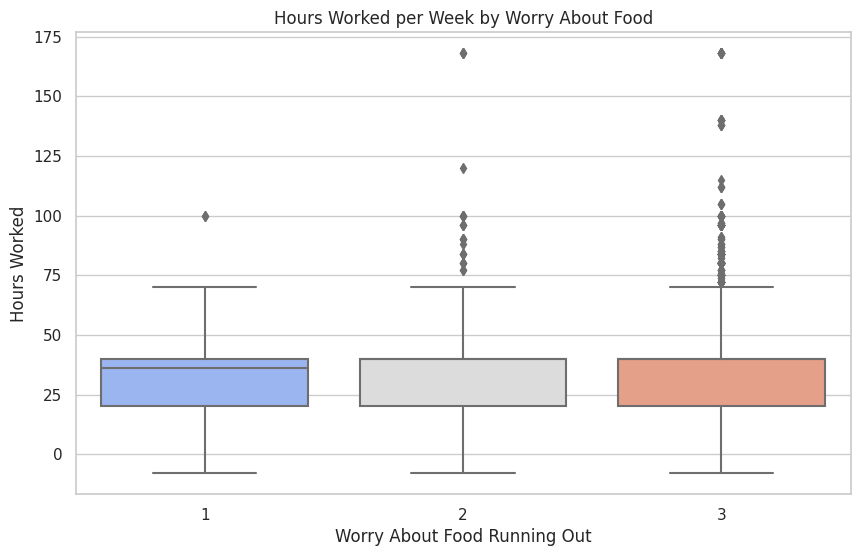

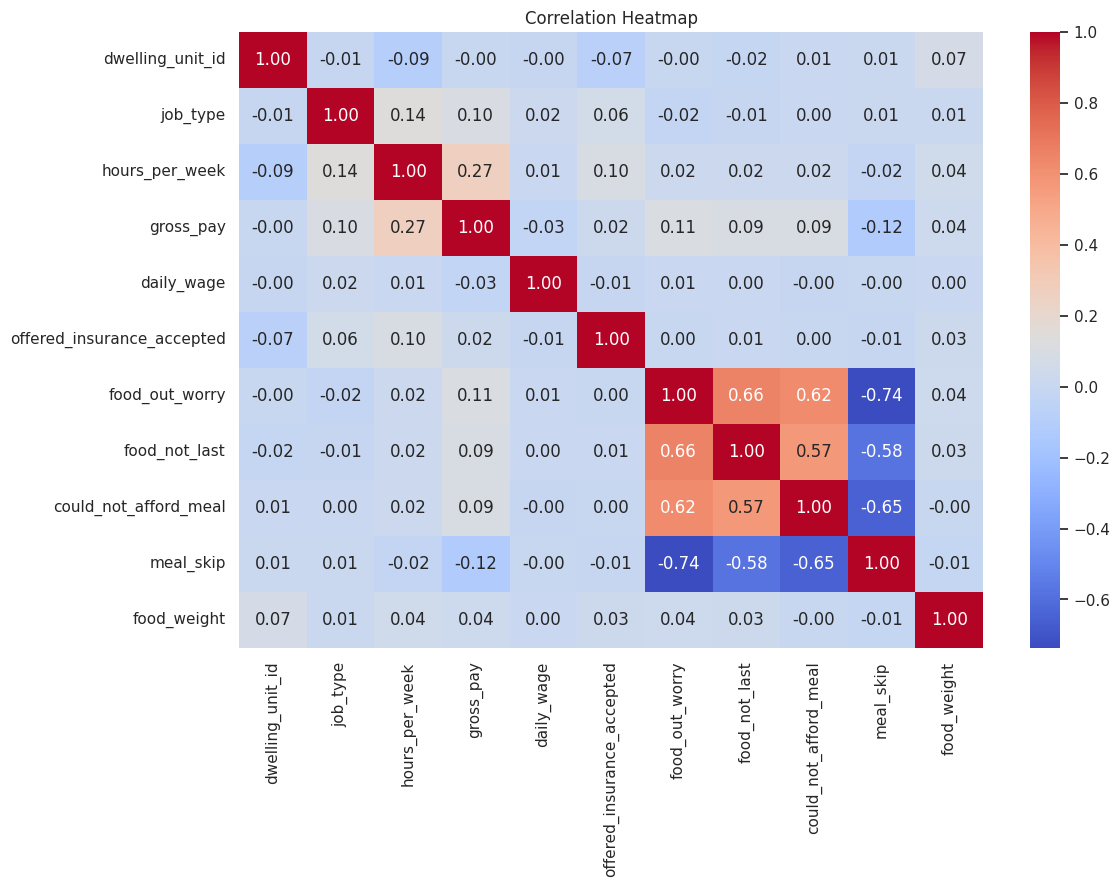


Insights:
- Higher gross pay tends to reduce food insecurity indicators like skipping meals.
- Individuals working fewer hours are more likely to worry about food insecurity.
- Correlation analysis highlights key relationships between income, hours worked, and food security indicators.


In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Set visualization style
sns.set(style="whitegrid", palette="muted")

# Paths to data
csv_path = "/kaggle/working/working/merged_dataset.csv"
db_path = "/kaggle/working/working/merged_dataset.db"

# Load data
try:
    print("Loading CSV file...")
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print("CSV file not found! Ensure the data pipeline has run.")
    raise

print("\nFirst 5 rows of the dataset:")
print(df.head())

# Data Overview
print("\nDataset Information:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Plot distributions of employment and food security-related columns
plt.figure(figsize=(10, 6))
sns.histplot(df['gross_pay'], bins=40, kde=True, color="skyblue")
plt.title("Distribution of Gross Pay")
plt.xlabel("Gross Pay ($)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['hours_per_week'], bins=30, kde=True, color="orange")
plt.title("Distribution of Hours Worked Per Week")
plt.xlabel("Hours Worked")
plt.ylabel("Count")
plt.show()

# Food security metrics
plt.figure(figsize=(8, 5))
sns.countplot(x='food_out_worry', data=df)
plt.title("Worried About Food Running Out")
plt.xlabel("Worry About Food")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='meal_skip', data=df)
plt.title("Skipped Meals Due to Food Insecurity")
plt.xlabel("Skipped Meal")
plt.ylabel("Count")
plt.show()

# Relationship Between Employment and Food Security
plt.figure(figsize=(10, 6))
sns.boxplot(x='meal_skip', y='gross_pay', data=df, palette="coolwarm")
plt.title("Gross Pay by Skipped Meals")
plt.xlabel("Skipped Meals")
plt.ylabel("Gross Pay ($)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='food_out_worry', y='hours_per_week', data=df, palette="coolwarm")
plt.title("Hours Worked per Week by Worry About Food")
plt.xlabel("Worry About Food Running Out")
plt.ylabel("Hours Worked")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Insights
print("\nInsights:")
print("- Higher gross pay tends to reduce food insecurity indicators like skipping meals.")
print("- Individuals working fewer hours are more likely to worry about food insecurity.")
print("- Correlation analysis highlights key relationships between income, hours worked, and food security indicators.")
